In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob
from pathlib import Path
import seaborn as sns
import os

In [45]:
def savefig(name, **kwargs):
    fn = "{}.pdf".format(name)
    plt.savefig(fn, bbox_inches="tight", **kwargs)

In [46]:
folders = glob.glob('results/*')
folders

['results/hati-2025-06-29']

In [47]:
levels = glob.glob(f'{folders[0]}/*')
levels

['results/hati-2025-06-29/lic3',
 'results/hati-2025-06-29/lic0',
 'results/hati-2025-06-29/lic2',
 'results/hati-2025-06-29/lic1']

In [48]:
def read_firestarter_from_lic(folder: str) -> pd.DataFrame:
    """
    folder: The folder that contains the measurements for the different number of cores.
    """
    df = pd.DataFrame()

    for file in glob.glob(f'{folder}/firestarter-*'):
        _name, index = Path(file).stem.split('-')
        index = int(index)
        
        read_df = pd.read_csv(file)

        for _index, row in read_df.iterrows():
            metric = row['metric']
            value = row['average']
            df = pd.concat([df, pd.DataFrame([{'metric': metric, 'value': value, 'index': index}])])

    return df

In [49]:
def read_uncore_from_lic(folder: str) -> pd.DataFrame:
    """
    folder: The folder that contains the measurements for the different number of cores.
    """
    df = pd.DataFrame()

    for file in glob.glob(f'{folder}/uncore-freq-*'):
        _name, _name2, index = Path(file).stem.split('-')
        index = int(index)
        
        read_df = pd.read_csv(file)

        for _index, row in read_df.iterrows():
            metric = row['name']
            value = row['average']
            df = pd.concat([df, pd.DataFrame([{'metric': metric, 'value': value, 'index': index}])])

    return df

In [50]:
all_data = pd.DataFrame()

for level in levels:
    lic_data = read_firestarter_from_lic(level)
    lic_data['level'] = os.path.basename(level)
    all_data = pd.concat([all_data, lic_data])

    lic_data = read_uncore_from_lic(level)
    lic_data['level'] = os.path.basename(level)
    all_data = pd.concat([all_data, lic_data])

all_data

,metric,value,index,level
0,ipc-estimate,4.645750e+00,57,lic3
0,perf-freq,3.294630e+00,57,lic3
0,perf-ipc,2.826710e+00,57,lic3
0,sysfs-powercap-rapl,4.542950e+02,57,lic3
0,sysfs-powercap-rapl/package-0,2.540070e+02,57,lic3
...,...,...,...,...
0,package_01_die_00,1.413070e+06,76,lic1
0,package_00_die_00,1.400000e+06,98,lic1
0,package_01_die_00,1.405840e+06,98,lic1
0,package_00_die_00,1.400130e+06,30,lic1


In [51]:
license_level_to_name = {
    'lic0': 'SSE',
    'lic1': 'AVX2',
    'lic2': 'AVX512',
    'lic3': 'AMX'
}

PERF_IPC = 'IPC of the compute kernel'
MAX_TURBO_FREQ = 'Maximum opportunistic turbo frequency [GHz]'
POWER_WATT = 'Power draw of package 0 [W]'
UNCORE_FREQ = 'Uncore frequency of package 0 [GHz]'

metric_name_map = {
    'perf-ipc': PERF_IPC,
    'perf-freq': MAX_TURBO_FREQ,
    'ipc-estimate': 'ipc-estimate',
    'package_00_die_00': UNCORE_FREQ,
    'package_01_die_00': UNCORE_FREQ,
    'sysfs-powercap-rapl': 'sysfs-powercap-rapl',
    'sysfs-powercap-rapl/package-0': POWER_WATT,
    'sysfs-powercap-rapl/package-0-dram': 'sysfs-powercap-rapl/package-0-dram',
    'sysfs-powercap-rapl/package-1': 'sysfs-powercap-rapl/package-1',
    'sysfs-powercap-rapl/package-1-dram': 'sysfs-powercap-rapl/package-1-dram',
}

all_data_copy = all_data.copy()

all_data_copy['level'] = all_data_copy['level'].apply(lambda v: license_level_to_name[v])
all_data_copy['metric'] = all_data_copy['metric'].apply(lambda v: metric_name_map[v])

all_data_pivot = all_data_copy.pivot_table('value', ['index', 'level'], 'metric')

all_data_pivot[UNCORE_FREQ] = all_data_pivot[UNCORE_FREQ] / 1e6

all_data_pivot

metric        IPC of the compute kernel  \
index level                               
0     AMX                       2.87639   
      AVX2                      3.88441   
      AVX512                    3.74335   
      SSE                       2.67581   
1     AMX                       2.87663   
...                                 ...   
98    SSE                       2.72825   
99    AMX                       2.87655   
      AVX2                      3.90178   
      AVX512                    3.74353   
      SSE                       2.70240   

metric        Maximum opportunistic turbo frequency [GHz]  \
index level                                                 
0     AMX                                         3.29278   
      AVX2                                        3.79336   
      AVX512                                      3.69182   
      SSE                                         3.79251   
1     AMX                                         3.29294   
...                                                   ...   
98    SSE                                         3.79347   
99    AMX                                         3.29292   
      AVX2                                        3.79340   
      AVX512                                      3.69195   
      SSE                                         3.79330   

metric        Power draw of package 0 [W]  \
index level                                 
0     AMX                         191.420   
      AVX2                        181.998   
      AVX512                      189.326   
      SSE                         169.375   
1     AMX                         191.736   
...                                   ...   
98    SSE                         164.760   
99    AMX                         191.253   
      AVX2                        182.178   
      AVX512                      189.304   
      SSE                         163.870   

metric        Uncore frequency of package 0 [GHz]  ipc-estimate  \
index level                                                       
0     AMX                                1.403615       4.72488   
      AVX2                               1.405330       7.36972   
      AVX512                             1.401335       6.89498   
      SSE                                1.401395       5.07245   
1     AMX                                1.402410       4.72700   
...                                           ...           ...   
98    SSE                                1.402285       5.18536   
99    AMX                                1.401840       4.72656   
      AVX2                               1.402920       7.40069   
      AVX512                             1.402535       6.89819   
      SSE                                1.401840       5.13862   

metric        sysfs-powercap-rapl  sysfs-powercap-rapl/package-0-dram  \
index level                                                             
0     AMX                 336.573                             12.3584   
      AVX2                327.199                             12.4151   
      AVX512              334.387                             12.3976   
      SSE                 321.713                             12.4160   
1     AMX                 337.030                             12.4119   
...                           ...                                 ...   
98    SSE                 309.983                             12.4137   
99    AMX                 336.314                             12.4232   
      AVX2                327.347                             12.4115   
      AVX512              334.553                             12.4149   
      SSE                 309.044                             12.3810   

metric        sysfs-powercap-rapl/package-1  \
index level                                   
0     AMX                           121.523   
      AVX2                          121.526   
      AVX512                        121.388   
   

In [52]:
PERFORMANCE = 'Performance [G Instructions/s]'
PERFORMANCE_DEVIATION = 'Deviation from mean performance [%]'
ENERGY_EFFICIENCY = 'Energy Efficiency [G Instructions/Watt/s]'
ENERGY_EFFICIENCY_DEVIATION = 'Deviation from maximum energy efficiency [%]'

all_data_pivot[PERFORMANCE] = all_data_pivot[PERF_IPC] * all_data_pivot[MAX_TURBO_FREQ]
all_data_pivot[ENERGY_EFFICIENCY] = all_data_pivot[PERFORMANCE] / all_data_pivot[POWER_WATT]

In [53]:
hue_order=['AMX', 'AVX512', 'AVX2', 'SSE']

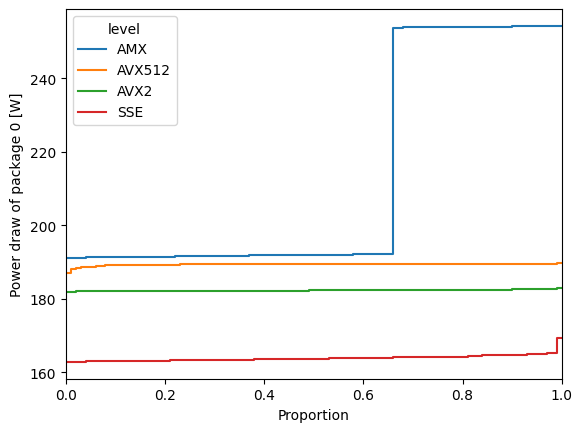

In [54]:
ax = sns.ecdfplot(data=all_data_pivot[POWER_WATT].reset_index(), y=POWER_WATT, hue='level', hue_order=hue_order)
savefig("../../thesis/fig/avx-frequency-uncore-anomaly-package-power-ecdf")

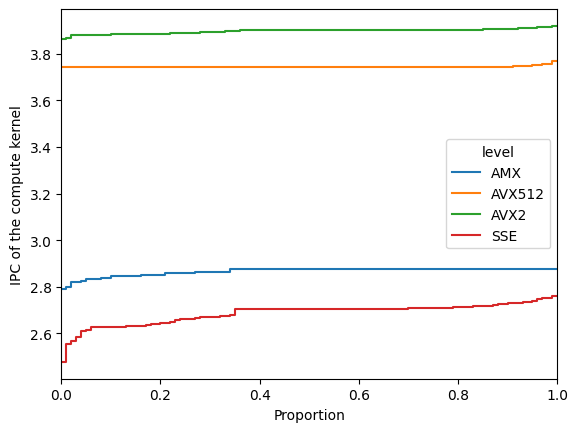

In [55]:
ax = sns.ecdfplot(data=all_data_pivot[PERF_IPC].reset_index(), y=PERF_IPC, hue='level', hue_order=hue_order)
savefig("../../thesis/fig/avx-frequency-uncore-anomaly-perf-ipc-ecdf")

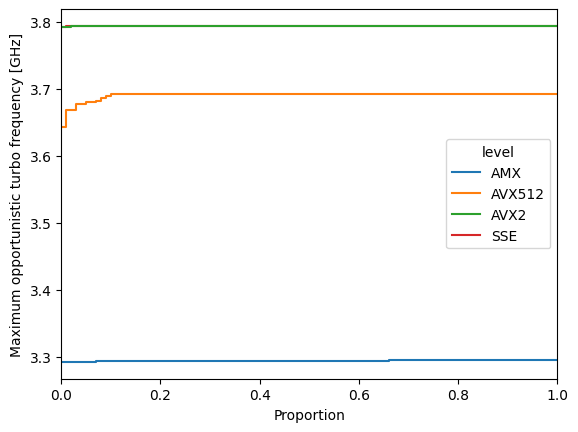

In [56]:
ax = sns.ecdfplot(data=all_data_pivot[MAX_TURBO_FREQ].reset_index(), y=MAX_TURBO_FREQ, hue='level', hue_order=hue_order)
savefig("../../thesis/fig/avx-frequency-uncore-anomaly-perf-freq-ecdf")

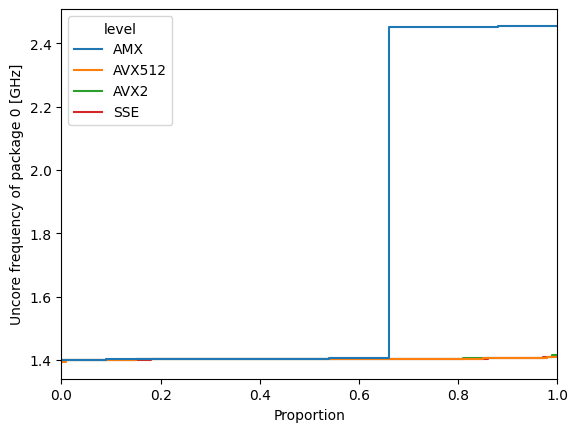

In [57]:
ax = sns.ecdfplot(data=all_data_pivot[UNCORE_FREQ].reset_index(), y=UNCORE_FREQ, hue='level', hue_order=hue_order)
savefig("../../thesis/fig/avx-frequency-uncore-anomaly-uncore-freq-ecdf")


In [58]:
df_performance_deviation = all_data_pivot[PERFORMANCE].reset_index()

for key, value in df_performance_deviation.groupby("level"):
    mean = value[PERFORMANCE].mean()
    df_performance_deviation.loc[value.index, [PERFORMANCE_DEVIATION]] = (value[PERFORMANCE] / mean - 1) * 100

print(df_performance_deviation)

     index   level  Performance [G Instructions/s]  \
0        0     AMX                        9.471319   
1        0    AVX2                       14.734966   
2        0  AVX512                       13.819774   
3        0     SSE                       10.148036   
4        1     AMX                        9.472570   
..     ...     ...                             ...   
395     98     SSE                       10.349535   
396     99     AMX                        9.472249   
397     99    AVX2                       14.801012   
398     99  AVX512                       13.820926   
399     99     SSE                       10.251014   

     Deviation from mean performance [%]  
0                               0.337463  
1                              -0.351952  
2                               0.011684  
3                              -0.350817  
4                               0.350711  
..                                   ...  
395                             1.627807  
396    

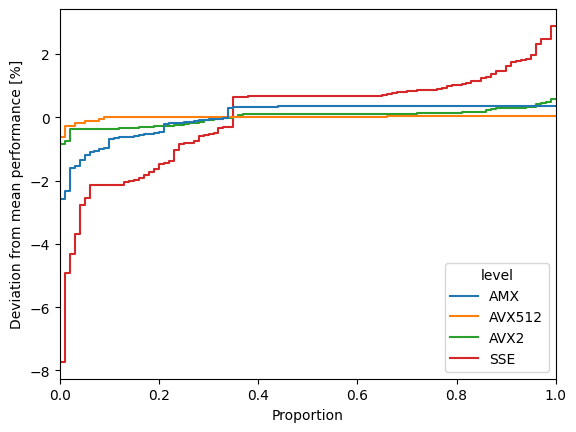

In [59]:
ax = sns.ecdfplot(data=df_performance_deviation, y=PERFORMANCE_DEVIATION, hue='level', hue_order=hue_order)
savefig("../../thesis/fig/avx-frequency-uncore-anomaly-performance-ecdf")

In [60]:
df_energy_efficiency_deviation = all_data_pivot[ENERGY_EFFICIENCY].reset_index()

for key, value in df_energy_efficiency_deviation.groupby("level"):
    max = value[ENERGY_EFFICIENCY].max()
    df_energy_efficiency_deviation.loc[value.index, [ENERGY_EFFICIENCY_DEVIATION]] = value[ENERGY_EFFICIENCY] / max  * 100

print(df_energy_efficiency_deviation)

     index   level  Energy Efficiency [G Instructions/Watt/s]  \
0        0     AMX                                   0.049479   
1        0    AVX2                                   0.080962   
2        0  AVX512                                   0.072995   
3        0     SSE                                   0.059915   
4        1     AMX                                   0.049404   
..     ...     ...                                        ...   
395     98     SSE                                   0.062816   
396     99     AMX                                   0.049527   
397     99    AVX2                                   0.081245   
398     99  AVX512                                   0.073009   
399     99     SSE                                   0.062556   

     Deviation from maximum energy efficiency [%]  
0                                       99.819079  
1                                       99.291598  
2                                       99.407364  
3          

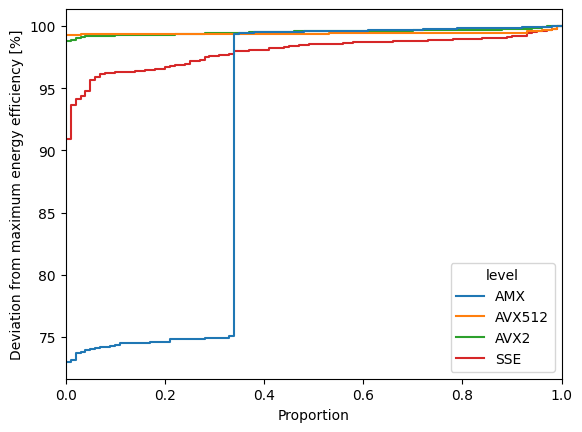

In [61]:
ax = sns.ecdfplot(data=df_energy_efficiency_deviation, y=ENERGY_EFFICIENCY_DEVIATION, hue='level', hue_order=hue_order)
savefig("../../thesis/fig/avx-frequency-uncore-anomaly-energy-efficiency-ecdf")